# Indexing optimization

* MultiVectorRetriever
* RAPTOR
* ColBERT

### MultiVectorRetriever

In [22]:
from langchain_community.document_loaders import TextLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import OpenSearchVectorSearch
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI
from langchain_core.documents import Document
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
import uuid
from langchain_community.document_loaders import PyPDFLoader
from langchain_ollama import ChatOllama

Loading pdf with format and more

In [16]:
collection_name = "summaries"
embeddings_model = OllamaEmbeddings(
    base_url='http://127.0.0.1:11434',
    model="deepseek-r1:1.5b"
)
# Load the document
loader = PyPDFLoader('../data/test.pdf')
docs = loader.load()

In [20]:
print("length of loaded docs: ", len(docs[0].page_content))
# Split the document
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(docs)

length of loaded docs:  2491


In [33]:
prompt_text = "Summarize the following document:\n\n{doc}"
	
prompt = ChatPromptTemplate.from_template(prompt_text)
llm = ChatOllama(
    base_url='http://127.0.0.1:11434',
    model="deepseek-r1:1.5b"
)
summarize_chain = {"doc": lambda x: x.page_content} | prompt | llm | StrOutputParser()
	

summaries = summarize_chain.batch(chunks, {"max_concurrency": 5})

In [37]:
import os

os_key = os.getenv("OPENSEARCH_INITIAL_ADMIN_PASSWORD")

vectorstore = OpenSearchVectorSearch(
    index_name=collection_name,
    embedding_function=embeddings_model,
    opensearch_url="https://localhost:9200",
    http_auth=("admin", os_key),
    use_ssl=False,
    verify_certs=False,
    ssl_assert_hostname=False,
    ssl_show_warn=False,
    engine="faiss",
)

In [40]:
store = InMemoryStore()
id_key = "doc_id"
	
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

In [41]:
doc_ids = [str(uuid.uuid4()) for _ in chunks]
	
summary_docs = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(summaries)
]

In [ ]:
retriever.vectorstore.add_documents(summary_docs)
retriever.docstore.mset(list(zip(doc_ids, chunks)))
# vector store retrieves the summaries


In [78]:
sub_docs = retriever.vectorstore.similarity_search(
    "Describe Alejandro")

In [79]:
retrieved_docs = retriever.invoke("Describe Alejandro")

In [80]:
sub_docs

[Document(id='831addd3-f595-46c0-b531-a849620db036', metadata={'doc_id': 'd8e8d6e2-973e-4f35-bb83-b2b579827fec'}, page_content="<think>\nOkay, I need to summarize this document. Let me read through it first.\n\nAlejandro Cespón has a job title that's a bit tricky: he's both an Artifical Intelligence Researcher and a Software Developer in Santa Clara, Cuba. He also has a Ph.D. in Computer Science from Granada University and is pursuing one more at UCLV. \n\nHis education includes a Master's degree starting December 2024, then a Bachelor's degree from the same university and Vocational Institute of Exact Sciences, ending in December 2023. He got his bachelor's before he started his Ph.D.\n\nHe also has a high school diploma from a Vocational Institute of Exact Sciences in Spanish and another in Mathematics High School Cuabana Preselection.\n\nHis contact information is provided: email, phone number, address, etc. His educational background shows he's into both AI research and software de

In [81]:
retrieved_docs

[Document(metadata={'producer': 'MiKTeX-dvipdfmx (20220710)', 'creator': 'LaTeX with hyperref', 'creationdate': '2025-07-10T17:14:12-04:00', 'source': '../data/test.pdf', 'total_pages': 4, 'page': 0, 'page_label': '1'}, page_content='Alejandro Cespón\nARTiFiCiALINTELLiGENCERESEARCHER · SOFTWAREMiDDEVELOPER\nSanta Clara, Villa Clara, Cuba\nć cesponalejandro@gmail.com | ^ acferriol | ] alejandro-cespon-b36771209 | Ȉ 0000-0002-8584-6958 | Ƹ Alejandro-Cespon-Ferriol | Ǒ alejandrocespon\n| ŵ Alejandro Cespón Ferriol | 24 years\n“Lifeisthis...,Ilikethis”\nHarveySpecter\nEducation\nGranadaUniversity Granada,Spain\nPHDONCOMPUTERSCiENCE Nov. 2024‑Present\n• DoctoralProgrammeinInformationandCommunicationTechnologies(B25/56/1).\nUCLV(CentralUniversity”MartaAbreu”ofLasVillas) VillaClara,Cuba\nMASTERONCOMPUTERSCiENCE Dec. 2023‑Sept. 2024\n• Studyingfromundergraduatebyaspecialtrainingplan\nUCLV(CentralUniversity”MartaAbreu”ofLasVillas) VillaClara,Cuba\nB.S.ONCOMPUTERSCiENCE Sep. 2019‑Dec. 2023\n• Go

### RAPTOR: Recursive Abstractive Processing for Tree-Organized Retrieval

IMPLEMENTAR!!!!!!

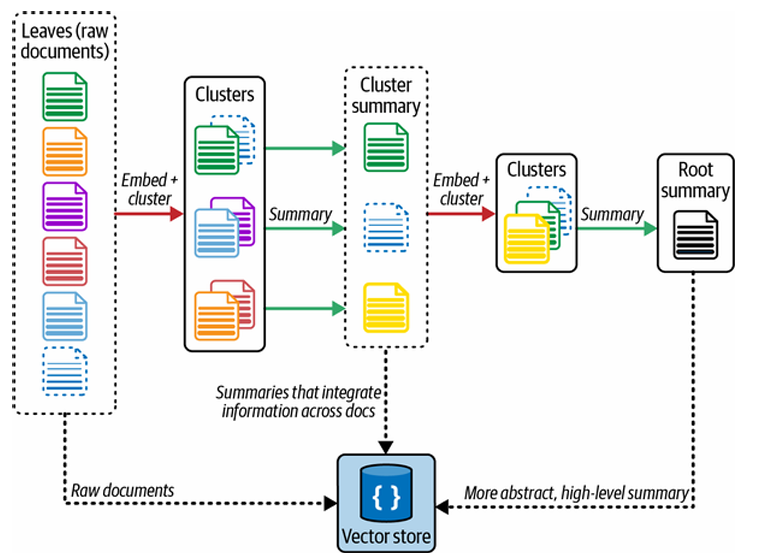

In [83]:
###############################
######### IMPLEMENTAR #########
########### RAPTOR ############
###############################

### ColBERT

In [ ]:
# RAGatouille is a library that makes it simple to use ColBERT
#! pip install -U ragatouille

from ragatouille import RAGPretrainedModel
import requests

In [7]:
def get_wikipedia_page(title: str):
    """
    Retrieve the full text content of a Wikipedia page.

    :param title: str - Title of the Wikipedia page.
    :return: str - Full text content of the page as raw string.
    """
    # Wikipedia API endpoint
    URL = "https://en.wikipedia.org/w/api.php"

    # Parameters for the API request
    params = {
        "action": "query",
        "format": "json",
        "titles": title,
        "prop": "extracts",
        "explaintext": True,
    }

    # Custom User-Agent header to comply with Wikipedia's best practices
    headers = {"User-Agent": "RAGatouille_tutorial/0.0.1"}

    response = requests.get(URL, params=params, headers=headers)
    data = response.json()

    # Extracting page content
    page = next(iter(data["query"]["pages"].values()))
    return page["extract"] if "extract" in page else None

In [8]:
full_document = get_wikipedia_page("Hayao_Miyazaki")
full_document

'Hayao Miyazaki (宮崎 駿 or 宮﨑 駿, Miyazaki Hayao; [mijaꜜzaki hajao]; born January 5, 1941) is a Japanese animator, filmmaker, and manga artist. He co-founded Studio Ghibli and serves as honorary chairman. Throughout his career, Miyazaki has attained international acclaim as a masterful storyteller and creator of Japanese animated feature films, and is widely regarded as one of the most accomplished filmmakers in the history of animation.\nBorn in Tokyo City, Miyazaki expressed interest in manga and animation from an early age. He joined Toei Animation in 1963, working as an inbetween artist and key animator on films like Gulliver\'s Travels Beyond the Moon (1965), Puss in Boots (1969), and Animal Treasure Island (1971), before moving to A-Pro in 1971, where he co-directed Lupin the Third Part I (1971–1972) alongside Isao Takahata. After moving to Zuiyō Eizō (later Nippon Animation) in 1973, Miyazaki worked as an animator on World Masterpiece Theater and directed the television series Futu

In [ ]:
RAG = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

## Create an index
RAG.index(
    collection=[full_document],
    index_name="Miyazaki-123",
    max_document_length=180,
    split_documents=True,
)

#query
results = RAG.search(query="What animation studio did Miyazaki found?", k=3)
results

#utilize langchain retriever
retriever = RAG.as_langchain_retriever(k=3)
retriever.invoke("What animation studio did Miyazaki found?")